# Unzip File

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/OMSCS/OMSCS_DL_Project/GenImage/BigGAN

/content/drive/My Drive/OMSCS/OMSCS_DL_Project/GenImage/BigGAN


In [3]:
! ls

BigGAN			     imagenet_ai_0419_biggan.z03  imagenet_ai_0419_biggan.z07
imagenet_ai_0419_biggan      imagenet_ai_0419_biggan.z04  imagenet_ai_0419_biggan.zip
imagenet_ai_0419_biggan.z01  imagenet_ai_0419_biggan.z05  unsplit.zip
imagenet_ai_0419_biggan.z02  imagenet_ai_0419_biggan.z06


In [4]:
! pwd

/content/drive/My Drive/OMSCS/OMSCS_DL_Project/GenImage/BigGAN


In [5]:
! ls /content/sample_data

anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md


In [6]:
! unzip unsplit.zip -d /content/sample_data/BigGAN/

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008906.JPEG  
  inflating: /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008909.JPEG  
  inflating: /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008920.JPEG  
  inflating: /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008926.JPEG  
  inflating: /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008936.JPEG  
  inflating: /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008940.JPEG  
  inflating: /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008945.JPEG  
  inflating: /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00008953.JPEG  
  inflating: /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ILSVRC2012_val_00

In [ ]:
# %cp -r /content/sample_data/BigGAN/ /content/drive/MyDrive/OMSCS_DL_Project/GenImage/BigGAN/

In [ ]:
# ! zip -F imagenet_ai_0508_adm.zip --out unsplit.zip

## Check Number of files

In [ ]:
! ls /content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/ai | wc -l

ls: cannot access '/content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/ai': No such file or directory
0


In [ ]:
! ls /content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/nature/ | wc -l

ls: cannot access '/content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/nature/': No such file or directory
0


In [ ]:
! ls /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/ai | wc -l

ls: cannot access '/content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/ai': No such file or directory
0


In [ ]:
! ls /content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/ | wc -l

ls: cannot access '/content/sample_data/BigGAN/imagenet_ai_0419_biggan/val/nature/': No such file or directory
0


Show Image

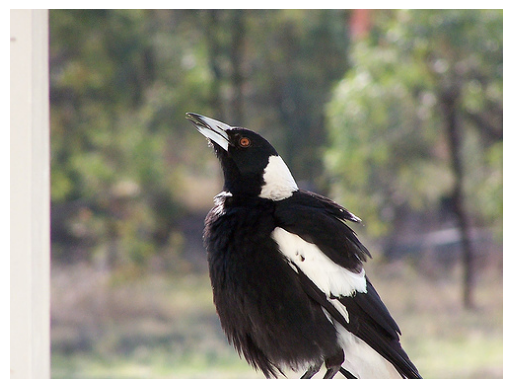

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure()
img = mpimg.imread('/content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/nature/n01582220_4551.JPEG')
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

# Prepare Dataloader

In [10]:
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.io import read_image

import torch

from skimage import io, transform

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
dataset_type = 'val'
model_type = 'nature'
root_dir = '/content/sample_data/BigGAN/imagenet_ai_0419_biggan'

image_name = os.listdir(os.path.join(root_dir, dataset_type, model_type))


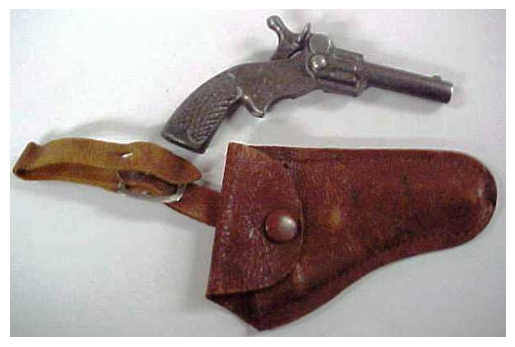

In [ ]:
image_name = os.path.join(root_dir, dataset_type, model_type,image_name[100])
plt.figure()
img = mpimg.imread(image_name)
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

In [64]:

# class GenImageDataset(Dataset):
#     """GenImage dataset."""
#     def __init__(self, root_dir, dataset_type, model_type, transform=None):
#         """
#         Args:
#             root_dir (string): Directory with all the images.
#             transform (callable, optional): Optional transform to be applied
#                 on a sample.
#         """
#         self.root_dir = root_dir
#         self.dataset_type = dataset_type
#         self.model_type = model_type
#         self.transform = transform

#         self.image_names = os.listdir(os.path.join(self.root_dir, self.dataset_type, self.model_type))

#     def __len__(self):
#         return len(os.listdir(os.path.join(self.root_dir, self.dataset_type, self.model_type)))

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()


#         image_name = os.path.join(self.root_dir, self.dataset_type, self.model_type,self.image_names[idx])

#         # handle broken images
#         if os.path.exists(image_name) and os.path.getsize(image_name) > 0:
#           image = read_image(image_name)
#         else:
#           image = torch.zeros((3,256,256))

#         # handle images without 3 layers
#         if image.shape[0] == 1:
#             image = torch.cat((image,image,image),0)

#         if image.shape[0] == 4:
#             image = image[:3]

#         model_type = self.model_type

#         if model_type == 'ai':
#             model_type_num = 1
#         else:
#             model_type_num = 0

#         dataset_type = self.dataset_type


#         image_name = self.image_names[idx]

#         sample = {'image': image,'model_type':model_type_num,'dataset_type':dataset_type,'image_name':image_name}

#         if self.transform:
#             sample = self.transform(sample)

#         return sample



In [65]:
# example: plots do not have three layers
# from IPython.display import Image
# Image(filename='/content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/nature/n02092002_1032.JPEG')

In [66]:

# class Rescale(object):
#     """Rescale the image in a sample to a given size.

#     Args:
#         output_size (tuple or int): Desired output size. If tuple, output is
#             matched to output_size. If int, smaller of image edges is matched
#             to output_size keeping aspect ratio the same.
#     """
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, sample):
#         image = sample['image']

#         new_h, new_w = int(self.output_size), int(self.output_size)

#         image = transforms.Resize([new_h, new_w])(image)


#         model_type = sample['model_type']
#         dataset_type = sample['dataset_type']
#         image_name = sample['image_name']

#         sample = {'image': image,'model_type':model_type,'dataset_type':dataset_type,'image_name':image_name}

#         return sample

In [78]:
%cd /content/drive/My Drive/OMSCS/OMSCS_DL_Project/Deep_Learning_Final_Project/Code

/content/drive/My Drive/OMSCS/OMSCS_DL_Project/Deep_Learning_Final_Project/Code


In [79]:
! ls

data_prep_util.py


In [89]:
del GenImageDataset, Rescale

In [90]:
from data_prep_util import GenImageDataset, Rescale

In [91]:

dataset_type = 'train'
# model_type = 'nature'
root_dir = '/content/sample_data/BigGAN/imagenet_ai_0419_biggan'
BigGen_train_nature = GenImageDataset(root_dir, dataset_type, 'nature'
                              ,transform=transforms.Compose([Rescale(256)])
                               )
BigGen_train_ai = GenImageDataset(root_dir, dataset_type, 'ai'
                              ,transform=transforms.Compose([Rescale(256)])
                               )
BigGen_train = torch.utils.data.ConcatDataset([BigGen_train_nature, BigGen_train_ai])

In [88]:
dataset_type = 'val'
BigGen_val_nature = GenImageDataset(root_dir, dataset_type, 'nature'
                              ,transform=transforms.Compose([Rescale(256)])
                               )
BigGen_val_ai = GenImageDataset(root_dir, dataset_type, 'ai'
                              ,transform=transforms.Compose([Rescale(256)])
                               )
BigGen_val = torch.utils.data.ConcatDataset([BigGen_val_nature, BigGen_val_ai])

In [60]:
len(BigGen_train)

324000

In [61]:
len(BigGen_val)

12000

In [62]:
BigGen_train[100]

{'image': tensor([[[202, 201, 202,  ..., 173, 170, 170],
          [200, 201, 200,  ..., 178, 173, 174],
          [199, 201, 199,  ..., 173, 164, 164],
          ...,
          [188, 188, 188,  ..., 177, 175, 175],
          [190, 189, 190,  ..., 176, 175, 174],
          [189, 188, 189,  ..., 177, 175, 174]],
 
         [[209, 210, 210,  ..., 181, 177, 176],
          [207, 210, 210,  ..., 182, 181, 182],
          [207, 210, 209,  ..., 178, 170, 171],
          ...,
          [200, 200, 200,  ..., 185, 185, 185],
          [201, 200, 200,  ..., 184, 185, 184],
          [199, 198, 199,  ..., 185, 185, 184]],
 
         [[220, 219, 218,  ..., 192, 190, 189],
          [218, 219, 217,  ..., 196, 192, 192],
          [218, 219, 218,  ..., 192, 182, 182],
          ...,
          [214, 214, 214,  ..., 196, 195, 195],
          [212, 212, 213,  ..., 195, 195, 194],
          [209, 208, 211,  ..., 198, 197, 196]]], dtype=torch.uint8),
 'model_type': 'nature',
 'dataset_type': 'train'}

In [ ]:
BigGen_train[100]['image'].shape

torch.Size([3, 256, 256])

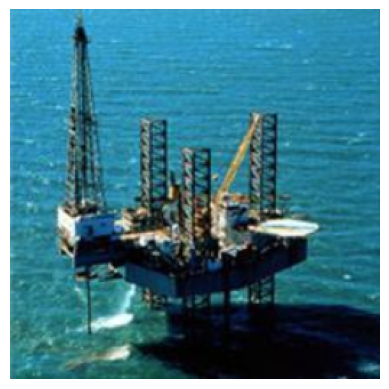

In [ ]:
plt.figure()
img = BigGen_train[100]['image']
imgplot = plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [ ]:
next(iter(BigGen_train))

# Create Dataloader

In [23]:
# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(BigGen_train, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(BigGen_val, batch_size=64, shuffle=True)

https://discuss.pytorch.org/t/dataloader-resets-dataset-state/27960

https://discuss.pytorch.org/t/pytorch-dataloaders-in-memory/118471

# Try Swin Transform

In [14]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [15]:
# Hyperparameters and configurations
class Config:
    # for data loader
    batch_size = 32
    num_workers = 4

    # number of epochs during training
    num_epochs = 8

    # learning rate for learnable parameters
    learning_rate = 0.0002

    # Define an MLP with 2 or 3 layers
    hidden_dim1 = 500
    hidden_dim2 = 500

    # dropout in head
    dropout = 0.25

    # Set to False to disable the high pass filter
    use_high_pass_filter = False

    # Adjust alpha between 0 and 1 for the desired effect for the high pass filter
    alpha_value = 0.25

    # Set to True if you want to use pretrained weights
    pretrained = False

In [16]:
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained Swin Transformer model
# model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1, progress=True)

# Initialize the Swin Transformer model without pretrained weights
model = models.swin_t(pretrained=Config.pretrained)  # Notice pretrained is set to False


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

classes = ['ai','nature']

mlp_head = nn.Sequential(
    nn.Linear(model.head.in_features, Config.hidden_dim1),
    nn.ReLU(),
    nn.Dropout(Config.dropout),
    nn.Linear(Config.hidden_dim1, Config.hidden_dim2),
    nn.ReLU(),
    nn.Dropout(Config.dropout),
    nn.Linear(Config.hidden_dim2, len(classes))
).to(device)

# Update the classifier head to the new MLP
model.head = mlp_head


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
criterion = nn.CrossEntropyLoss()

def accuracy(predictions, labels):
    _, preds = torch.max(predictions, 1)
    return (preds == labels).float().mean().item()

In [24]:
trainloader = DataLoader(BigGen_train, batch_size=Config.batch_size, shuffle=False)
testloader = DataLoader(BigGen_val, batch_size=Config.batch_size, shuffle=False)

In [ ]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")
# print(device)

In [ ]:
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import time  # Import the time module

scaler = GradScaler()  # Initialize the GradScaler

train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []
total_training_start = time.time()  # Record the start time of the total training

for epoch in range(Config.num_epochs):
    epoch_start = time.time()  # Record the start time of the epoch

    train_loss, train_acc, val_loss, val_acc = 0.0, 0.0, 0.0, 0.0

    # Training Phase
    model.train()
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1} TRAIN", ncols=100)
    for i, data in pbar:
        inputs = data['image']
        inputs = inputs.to(torch.float)
        inputs = inputs.to(device)

        labels = data['model_type']
        labels = labels.to(device)

        dataset = data['dataset_type']
        image_name = data['image_name']

        # inputs, labels, dataset = inputs.cuda(), labels.cuda(), dataset.cuda()

        # inputs = inputs.cuda()

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        train_acc += accuracy(outputs, labels)

        pbar.set_description(f"Epoch {epoch+1} TRAIN Loss: {loss.item():.4f}")

    # Validation Phase
    model.eval()
    pbar = tqdm(enumerate(testloader), total=len(testloader), desc=f"Epoch {epoch+1} VAL", ncols=100)
    with torch.no_grad():
        for i, data in pbar:
            inputs = data['image']
            inputs = inputs.to(torch.float)
            inputs = inputs.to(device)

            labels = data['model_type']
            labels = labels.to(device)

            dataset = data['dataset_type']
            image_name = data['image_name']

            # inputs, labels, dataset = inputs.cuda(), labels.cuda(), dataset.cuda()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += accuracy(outputs, labels)

            pbar.set_description(f"Epoch {epoch+1} VAL Loss: {loss.item():.4f}")

    epoch_end = time.time()  # Record the end time of the epoch
    epoch_duration = (epoch_end - epoch_start) / 60  # Calculate the duration in minutes

    train_loss /= len(trainloader)
    train_acc /= len(trainloader)
    val_loss /= len(testloader)
    val_acc /= len(testloader)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch Summary {epoch+1}/{Config.num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    print(f"Epoch Duration: {epoch_duration:.2f} minutes")
    print('-' * 60)

total_training_end = time.time()  # Record the end time of the total training
total_training_duration = (total_training_end - total_training_start) / 60  # Calculate the total duration in minutes
print('Finished Training')
print(f"Total Training Time: {total_training_duration:.2f} minutes")

#https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch


Epoch 1 VAL Loss: 0.0000: 100%|███████████████████████████████████| 375/375 [01:06<00:00,  5.60it/s]


Epoch Summary 1/8
Train Loss: 0.0223, Train Acc: 99.90%, Val Loss: 34.8750, Val Acc: 50.00%
Epoch Duration: 37.08 minutes
------------------------------------------------------------


Epoch 2 VAL Loss: 0.0000: 100%|███████████████████████████████████| 375/375 [00:52<00:00,  7.21it/s]


Epoch Summary 2/8
Train Loss: 0.0311, Train Acc: 99.85%, Val Loss: 23.0625, Val Acc: 50.00%
Epoch Duration: 36.57 minutes
------------------------------------------------------------


Epoch 3 VAL Loss: 0.0000: 100%|███████████████████████████████████| 375/375 [00:51<00:00,  7.29it/s]


Epoch Summary 3/8
Train Loss: 0.0343, Train Acc: 99.83%, Val Loss: 14.4844, Val Acc: 50.00%
Epoch Duration: 36.25 minutes
------------------------------------------------------------


Epoch 4 VAL Loss: 0.0000: 100%|███████████████████████████████████| 375/375 [00:52<00:00,  7.12it/s]


Epoch Summary 4/8
Train Loss: 0.0354, Train Acc: 99.67%, Val Loss: 16.2969, Val Acc: 50.00%
Epoch Duration: 36.56 minutes
------------------------------------------------------------


Epoch 5 TRAIN Loss: 0.0000:  24%|███████                       | 2399/10125 [09:33<30:46,  4.18it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-76-f2e7d5dc9722>", line 19, in <cell line: 11>
    for i, data in pbar:
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1182, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 674, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.d

In [25]:
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import time  # Import the time module

scaler = GradScaler()  # Initialize the GradScaler

train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []
total_training_start = time.time()  # Record the start time of the total training

for epoch in range(Config.num_epochs):
    epoch_start = time.time()  # Record the start time of the epoch

    train_loss, train_acc, val_loss, val_acc = 0.0, 0.0, 0.0, 0.0

    # Training Phase
    model.train()
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1} TRAIN", ncols=100)
    for i, data in pbar:

        inputs = data['image']
        inputs = inputs.to(torch.float)
        inputs = inputs.to(device)

        labels = data['model_type']
        labels = labels.to(device)

Epoch 1 TRAIN:   0%|                                                      | 0/10125 [00:00<?, ?it/s]


AttributeError: ignored

In [76]:
# from itertools import islice

# for i,data in enumerate(trainloader):
#   if i>5200:
#     print(data['image'].shape)
#     print(i)


In [ ]:
# plots with errors
# /content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/ai/116_biggan_00098.png
# /content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/ai/116_biggan_00107.png
plt.figure()
img = mpimg.imread('/content/sample_data/BigGAN/imagenet_ai_0419_biggan/train/ai/116_biggan_00094.png')
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

SyntaxError: ignored

<Figure size 640x480 with 0 Axes>

In [40]:
import gc

del model, inputs, labels, dataset, image_name
gc.collect()
torch.cuda.empty_cache()

NameError: ignored

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)